## This is the k-nearest neighbors workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement k-nearest neighbors.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with the data, training and evaluating a simple classifier, k-fold cross validation, and as a Python refresher.

## Import the appropriate libraries

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from utils.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import numpy as np
import matplotlib.pyplot as plt
import time

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set the path to the CIFAR-10 data
cifar10_dir = '/Users/sujitsilas/Desktop/UCLA/Winter 2025/EE ENGR 247/Homeworks/HW2/student_copy/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyw

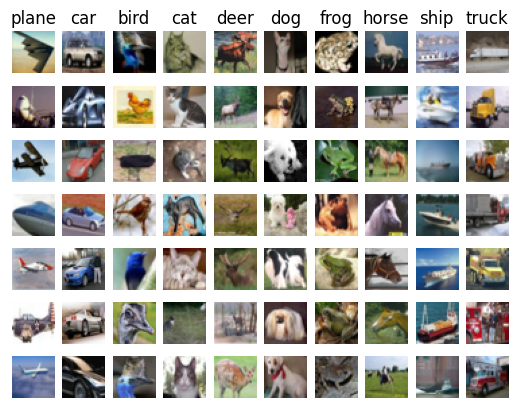

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# K-nearest neighbors

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [5]:
# Import the KNN class

from nndl import KNN

In [6]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

## Questions

(1) Describe what is going on in the function knn.train().

(2) What are the pros and cons of this training step?

## Answers

(1) The knn function simply stores the training data (X_train) and the corresponding labels (y_train) so they can be used later during the prediction phase to compute distances and make predictions.

(2) The pros are that it is relatively simple, straight forward, and fast. With its ability to store the entier dataset, it can adapt to different test cases without retraining. The cons are that the notion of diatance in a higher dimensional space becomes less intuitive. KNN takes up a lot of memory, may not be scalable and can involve high computational costs

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [7]:
# Implement the function compute_distances() in the KNN class.
# Do not worry about the input 'norm' for now; use the default definition of the norm
# in the code, which is the 2-norm.
# You should only have to fill out the clearly marked sections.

import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 16.23002815246582
Frobenius norm of L2 distances: 7906696.077040902


#### Really slow code

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops.

If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.


Formula: ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i * x_j

In [8]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

Time to run code: 0.49208498001098633
Difference in L2 distances between your KNN implementations (should be 0): 0.0


#### Speedup

Depending on your computer speed, you should see a 10-100x speed up from vectorization.  On our computer, the vectorized form took 0.36 seconds while the naive implementation took 38.3 seconds. 

### Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [9]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

# Calculate the training error for k=1
y_pred = knn.predict_labels(dists_L2_vectorized, k=1)  

# Calculate the number of incorrect predictions
num_incorrect = np.sum(y_pred != y_test)

# Calculate the training error rate
error = (num_incorrect / y_test.shape[0])

print(f"Training error rate: {error}")



Training error rate: 0.726


If you implemented this correctly, the error should be: 0.726.

This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great, considering that chance levels are 10%.

# Optimizing KNN hyperparameters

In this section, we'll take the KNN classifier that you have constructed and perform cross-validation to choose a best value of $k$, as well as a best choice of norm.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [10]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# Number of folds for cross-validation
num_folds = 5

# Shuffle the data indices
num_train = X_train.shape[0]
indices = np.arange(num_train)
np.random.shuffle(indices)

# Split the indices into folds
fold_size = num_train // num_folds
X_train_folds = []
y_train_folds = []

for i in range(num_folds):

    start_idx = i * fold_size
    if i == num_folds - 1: 
        end_idx = num_train
    else:
        end_idx = start_idx + fold_size

    fold_indices = indices[start_idx:end_idx]

    # Append the corresponding data and labels to the folds
    X_train_folds.append(X_train[fold_indices])
    y_train_folds.append(y_train[fold_indices])

# Print the number of samples in each fold to verify
for i in range(num_folds):
    print(f"Fold {i+1}: {X_train_folds[i].shape[0]} samples")


Fold 1: 1000 samples
Fold 2: 1000 samples
Fold 3: 1000 samples
Fold 4: 1000 samples
Fold 5: 1000 samples


### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

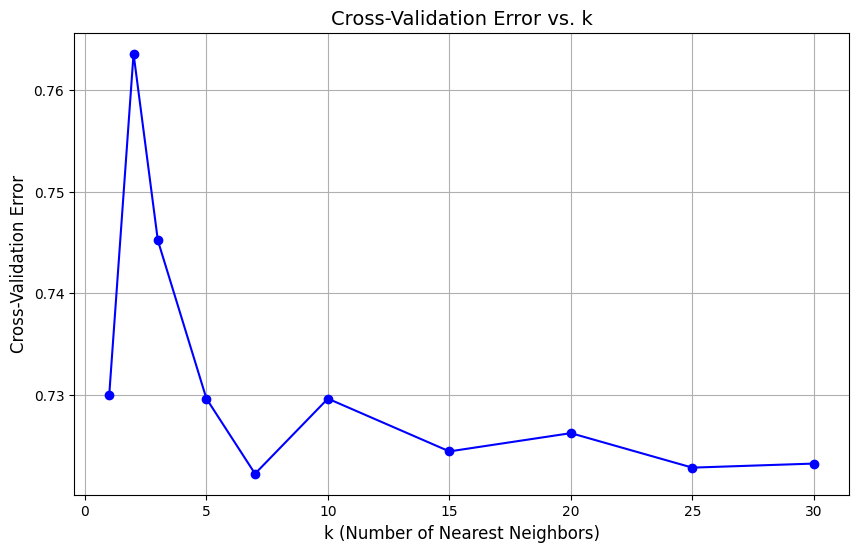

Computation time: 40.55 seconds


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

time_start = time.time()


ks = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]

cv_errors = []

for k in ks:
    fold_errors = [] 
    
    for i in range(num_folds):

        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:], axis=0)
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:], axis=0)
        

        knn = KNN()
        knn.train(X_train_fold, y_train_fold)
        

        dists = knn.compute_L2_distances_vectorized(X_val_fold)
        

        y_pred = knn.predict_labels(dists, k=k)
        

        fold_error = np.mean(y_pred != y_val_fold)
        fold_errors.append(fold_error)
    

    avg_error = np.mean(fold_errors)
    cv_errors.append(avg_error)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ks, cv_errors, marker='o', linestyle='-', color='b')
plt.xlabel('k (Number of Nearest Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Error', fontsize=12)
plt.title('Cross-Validation Error vs. k', fontsize=14)
plt.grid(True)
plt.show()

print('Computation time: %.2f seconds' % (time.time() - time_start))




## Questions:

(1) What value of $k$ is best amongst the tested $k$'s?

(2) What is the cross-validation error for this value of $k$?

In [12]:
print(f"Best k: {ks[np.argmin(cv_errors)]}")
print(f"Lowest error: {np.min(cv_errors)}")

Best k: 7
Lowest error: 0.7222000000000001


## Answers:

(1) k=20

(2) The lowest error rate was 0.722

### Optimizing the norm

Next, we test three different norms (the 1, 2, and infinity norms) and see which distance metric results in the best cross-validation performance.

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


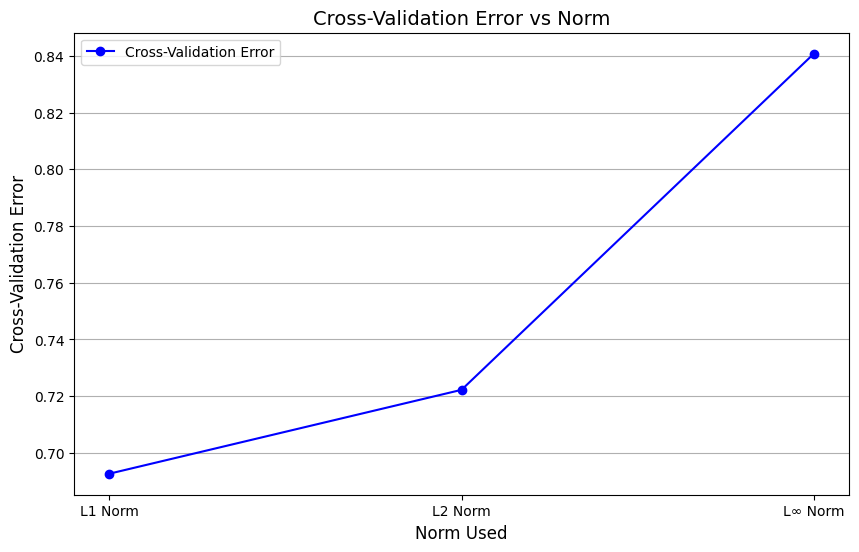

Computation time: 583.88 seconds
Best norm: L1 Norm
Lowest cross-validation error: 0.6926


In [21]:
time_start =time.time()
best_k = 7 
L1_norm = lambda x: np.linalg.norm(x, ord=1)
L2_norm = lambda x: np.linalg.norm(x, ord=2)
Linf_norm = lambda x: np.linalg.norm(x, ord= np.inf)
norms = [L1_norm, L2_norm, Linf_norm]

# Initialize storage for errors
cv_errors = []

time_start = time.time()

# Perform cross-validation for each norm
for norm in norms:
    fold_errors = [] 

    for i in range(num_folds):
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:], axis=0)
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:], axis=0)

        knn = KNN()
        knn.train(X_train_fold, y_train_fold)

        dists = knn.compute_distances(X=X_val_fold, norm=norm)

        y_pred = knn.predict_labels(dists, k=best_k)
        
        fold_error = np.mean(y_pred != y_val_fold)
        fold_errors.append(fold_error)

    avg_error = np.mean(fold_errors)
    cv_errors.append(avg_error)

# Plot the results
norm_names = ['L1 Norm', 'L2 Norm', 'L∞ Norm']
plt.figure(figsize=(10, 6))
plt.plot(norm_names, cv_errors, marker='o', linestyle='-', color='b', label="Cross-Validation Error")
plt.xlabel('Norm Used', fontsize=12)
plt.ylabel('Cross-Validation Error', fontsize=12)
plt.title('Cross-Validation Error vs Norm', fontsize=14)
plt.legend()
plt.grid(axis='y')
plt.show()

# Print computation time
print('Computation time: %.2f seconds' % (time.time() - time_start))

# Output the best norm and corresponding error
best_norm_idx = np.argmin(cv_errors)
print(f"Best norm: {norm_names[best_norm_idx]}")
print(f"Lowest cross-validation error: {cv_errors[best_norm_idx]:.4f}")

## Questions:

(1) What norm has the best cross-validation error?

(2) What is the cross-validation error for your given norm and k?

## Answers: 

(1) L1 norm has the lowest error

(2) The corss vlalidation error for the the L1 norm was 0.6926

# Evaluating the model on the testing dataset.

Now, given the optimal $k$ and norm you found in earlier parts, evaluate the testing error of the k-nearest neighbors model.

In [22]:
k_optimal = 7 
norm_optimal = L1_norm  

# Initialize the KNN model with the optimal k
knn = KNN()
knn.train(X_train, y_train)
dists = knn.compute_distances(X=X_test, norm=norm_optimal)

# Predict labels for the test set based on the optimal k
y_pred = []
for dist in dists:
    nearest_neighbors = np.argsort(dist)[:k_optimal] 
    label = np.bincount(y_train[nearest_neighbors]).argmax()
    y_pred.append(label)
y_pred = np.array(y_pred)


error = np.mean(y_pred != y_test)


print('Error rate achieved: {}'.format(error))

Error rate achieved: 0.698


In [23]:
naive_error = 0.726  # Training error for naive k=1, L2 norm
improvement = naive_error - error
print(f"Error improvement by cross-validation: {improvement:.4f}")


Error improvement by cross-validation: 0.0280


## Question:

How much did your error improve by cross-validation over naively choosing $k=1$ and using the L2-norm?

## Answer:

The error changed by 0.0280